# MSCA 32016 Stock News Investigation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('finance/finance.csv')

In [5]:
df.head()

,Symbol,Description,OrderID,Quantity,Action,Exchange,Side,Price,News
0,AAL,American Airlines Group Inc,1101,455000,A,1,B,44.05,0
1,AAPL,Apple Inc,1102,685000,A,1,B,128.75,0
2,ADBE,Adobe Systems Inc,1103,189000,A,1,B,113.36,0
3,ADI,Analog Devices Inc,1104,181000,A,1,B,76.17,0
4,ADP,Automatic Data Processing Inc,1105,953000,A,1,B,95.25,0


### Playbook

1. For a given symbol, order id, exchange, and side run an OLS on the price and news

In [6]:
import statsmodels.formula.api as smf

In [7]:
temp_50 = {50:True, 100:False, 0:False}
temp_100 = {50:False, 100:True, 0:False}
temp_mod = {'A': True, 'M': False}

df['is_50'] = df['News'].map(temp_50).map(int)
df['is_100'] = df['News'].map(temp_100).map(int)
df['is_add'] = df['Action'].map(temp_mod).map(int)

Find stocks that are highly correlated with news
Symbol, Side?, Rsquared

In [8]:
UniqueTimeFrames = (df.Symbol + '-' + df.Side + '-' + df.OrderID.map(str)).unique()

dfSymbol = {q : df for q in UniqueTimeFrames}

for key in dfSymbol.keys():
    dfSymbol[key] = df[:][df['Symbol'] + '-' + df['Side'].map(str) + '-' + df['OrderID'].map(str) == key]

In [9]:
for key in dfSymbol.keys():
    dfSymbol[key]['delta'] = dfSymbol[key]['Price'].diff()
    
for key in dfSymbol.keys():
    dfSymbol[key].fillna(0)

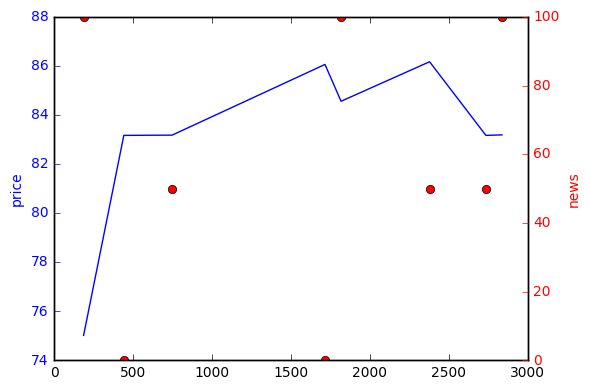

In [10]:
fig, ax1 = plt.subplots()
s1 = dfSymbol['EA-S-2234']['Price']
ax1.plot(s1, 'b-')
ax1.set_xlabel('')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('price', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = dfSymbol['EA-S-2234']['News']
ax2.plot(s2, 'ro')
ax2.set_ylabel('news', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

In [11]:
result_rsquared = {}
intercepts = {}
is_50_cf = {}
is_100_cf = {}

for key in dfSymbol:
    result = smf.ols(formula = "delta ~ is_50 + is_100", data = dfSymbol[key]).fit()      
    result_rsquared[key] = result.rsquared
    intercepts[key] = result.params[0]
    is_50_cf[key] = result.params[1]
    is_100_cf[key] = result.params[2]

names_trade = pd.DataFrame(list(result_rsquared.items()), \
                           columns=['Symbol', 'RSquared']).sort_values(by='RSquared', ascending=False)

intercepts = pd.DataFrame(list(intercepts.items()), \
                           columns=['Symbol', 'Intercept']).sort_values(by='Symbol', ascending=False)

is_50_cf = pd.DataFrame(list(is_50_cf.items()), \
                           columns=['Symbol', 'is_50_coefficient']).sort_values(by='Symbol', ascending=False)

is_100_cf = pd.DataFrame(list(is_100_cf.items()), \
                           columns=['Symbol', 'is_100_coefficient']).sort_values(by='Symbol', ascending=False)

names_trade = names_trade[names_trade['RSquared'] > 0.4]

names_trade

/Users/albhu/venv/vir_env/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-macosx-10.10-x86_64.egg/statsmodels/regression/linear_model.py:1353: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Symbol,RSquared
186,DISCK-S-3231,1.000000
87,BMRN-S-2217,0.997024
302,BBBY-S-1214,0.883003
182,ADP-S-2205,0.783320
15,CHKP-B-2121,0.672941
83,EA-S-2234,0.670998
44,AMZN-B-2111,0.621869
71,ILMN-S-2247,0.621049
167,ISRG-S-2251,0.614513
165,INTC-B-1149,0.611222


### General Investigation

1. Trade on the RSquared values that are relatively high. These are in the names_trade dataframe. Symbol + Action
2. Figure out what happens to the stock price for a News value: find the high/low and relative price to those values when there is a News Value
3. For the specific Symbol, Side, codify the action that should be taken when there is news

In [109]:
df_model = names_trade.merge(intercepts, on='Symbol').merge(is_50_cf, on='Symbol').merge(is_100_cf, on='Symbol')

In [110]:
df_model

,Symbol,RSquared,Intercept,is_50_coefficient,is_100_coefficient
0,DISCK-S-3231,1.000000,-0.450000,0.490000,0.000000
1,BMRN-S-2217,0.997024,0.046667,7.043333,0.000000
2,BBBY-S-1214,0.883003,0.542500,-1.092500,4.577500
3,ADP-S-2205,0.783320,0.726667,1.678333,-9.906667
4,CHKP-B-2121,0.672941,0.046667,2.993333,-1.013333
5,EA-S-2234,0.670998,5.515000,-5.975000,-6.255000
6,AMZN-B-2111,0.621869,-0.495000,6.425000,-2.460000
7,ILMN-S-2247,0.621049,-0.174000,1.674000,-0.706000
8,ISRG-S-2251,0.614513,0.008000,-2.918000,0.000000
9,INTC-B-1149,0.611222,-1.265000,6.125000,1.075000


### General Strategy

1. When the news coefficients are negatives, the prices will be lower 

In [84]:
df.groupby(['Symbol', 'Side'], sort=False)['Price'].max()
df.groupby(['Symbol', 'Side'], sort=False)['Price'].min()

dfPivot = pd.pivot_table(df, values = "Price", 
                             columns = ["Side"], index = ["Symbol", "News"])

In [85]:
dfPivot

Side                  B           S
Symbol News                        
AAL    0      42.631818   42.277727
       50     41.153333   43.540000
       100    43.083333   42.137778
AAPL   0     127.015200  128.130385
       50    124.405000  127.691667
       100   126.925000  127.387500
ADBE   0     111.569615  111.990500
       50    112.073333  113.261667
       100   113.455000  111.850000
ADI    0      76.145385   75.932000
       50     73.295000   76.325000
       100    74.831667   75.426667
ADP    0      96.795000   96.111250
       50     95.360000   98.322500
       100    98.948000   96.485000
ADSK   0      81.226364   81.329600
       50     81.216667   80.886667
       100    81.875000   81.352857
AKAM   0      70.302500   69.887857
       50     70.292500   69.196000
       100    69.067500   71.207500
ALXN   0     133.674231  134.438750
       50    133.498333  133.447500
       100   136.804000  132.415000
AMAT   0      33.585833   33.678214
       50     31.280000   33.966667
       100    35.064000   33.694000
AMGN   0     159.894762  159.936667
       50    159.685000  160.208333
       100   160.058000  160.143333
...                 ...         ...
FOXA   0      30.856562   30.729545
       50     29.036667   29.871667
       100    31.865000   30.880000
GILD   0      73.597000   74.471818
       50     72.806667   73.953333
       100    75.156000   72.903333
GOOG   0     793.823200  795.157778
       50    795.780000  792.035000
       100   794.785000  794.544286
GOOGL  0     815.363462  815.394286
       50    816.145000  815.120000
       100   815.300000  815.460000
HSIC   0     159.992609  160.083929
       50    159.750000  160.365000
       100   159.910000  160.150000
ILMN   0     162.019091  162.615600
       50    162.238000  162.634000
       100   162.301250  162.232500
INCY   0     125.613030  127.156842
       50    124.465000  127.984000
       100   124.452000  127.903333
INTC   0      35.318148   35.781786
       50     37.430000   34.700000
       100    36.323333   36.540000
INTU   0     119.758000  119.371818
       50    119.076000  117.786000
       100   119.020000  119.856000
ISRG   0     696.816296  696.859000
       50    697.150000  697.660000
       100   694.512000  697.130000

[153 rows x 2 columns]